<a href="https://colab.research.google.com/github/bbqgonewrong/weather_prediction_ridge/blob/main/Weather_Forecasting_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Importing libraries

In [42]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt



##Grabbing the data set from Tensorflow

In [4]:
#Importing dataset
zip_path = tf.keras.utils.get_file(origin = 'https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
                                   fname = 'jena_climate_2009_2016.csv.zip',
                                   extract = True)
csv_path,_ = os.path.splitext(zip_path)

##EDA

In [5]:
df = pd.read_csv(csv_path)

In [7]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [8]:
#Converting the index to date time
df.index = pd.to_datetime(df['Date Time'],format = '%d.%m.%Y %H:%M:%S')

In [59]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,,
2009-01-01 00:10:00,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


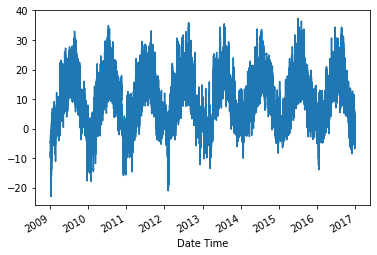

In [15]:
#Plotting the temperature
temp = df['T (degC)']
temp.plot()

##Creating the dataset from raw data

In [14]:
#Look at the last 4 values in order to set them as the target variable
# x = [[[1],[2]],[3],[4],[5]]] y= [6]
# [[[2],[3],[4],[5],[6]]] y = [7]

def df_to_X_y(df,window_size = 5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X),np.array(y)

In [28]:
#Call the function to store the previous 5 temperatures for the row defined.
window_size = 5
X,y = df_to_X_y(temp,window_size)
X.shape,y.shape

((420546, 5, 1), (420546,))

In [32]:
X_train,y_train = X[:357464], y[:357464]
X_val,y_val = X[357464:378490], y[357464:378490]
X_test,y_test = X[378490:], y[378490:]

In [34]:
X_val.shape,y_val.shape

((21026, 5, 1), (21026,))

##Creating the model

In [26]:
model1 = Sequential()
model1.add(InputLayer((5,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


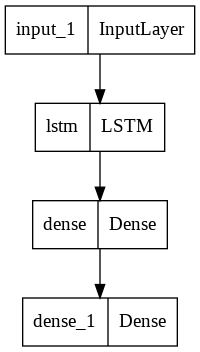

In [27]:
#Plotting the model for viewing
tf.keras.utils.plot_model(
    model1,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

##Compiling the model and the optimizers and defining callbacks

In [35]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss=MeanSquaredError(),optimizer=Adam(learning_rate = 1e-4),metrics = [RootMeanSquaredError()])


##Training the LSTM model

In [ ]:
model1.fit(X_train,y_train,validation_data = (X_val,y_val),epochs = 10,callbacks=[cp])

In [39]:
model1 = load_model('model1/')

##Testing the model performance on training data

In [41]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data = {'Train Predictions': train_predictions,'Actual Value': y_train})

##Making the plot for predicted vs the actual value

Text(0.5, 1.0, 'Predicted value vs Actual value')

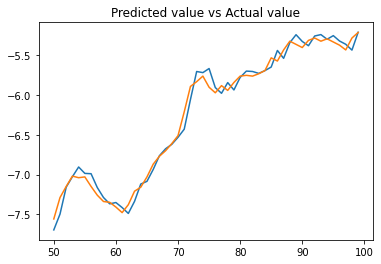

In [50]:
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actual Value'][50:100])
plt.title('Predicted value vs Actual value')

##Testing the model performance on Validation data

In [55]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data = {'Train Predictions': val_predictions,'Actual Value': y_val})

###Plotting

Text(0.5, 1.0, 'Predicted value vs Actual value')

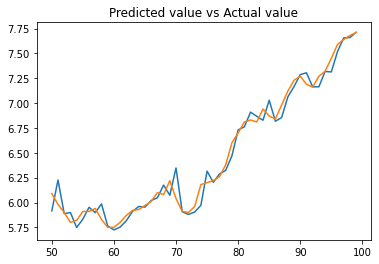

In [56]:
plt.plot(val_results['Train Predictions'][50:100])
plt.plot(val_results['Actual Value'][50:100])
plt.title('Predicted value vs Actual value')

##Evaluating the model performance on Test data

In [57]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data = {'Test Predictions': test_predictions,'Actual Value': y_test})

Text(0.5, 1.0, 'Predicted value vs Actual value')

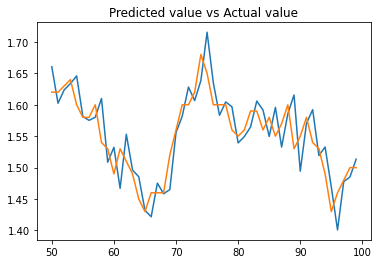

In [58]:
plt.plot(test_results['Test Predictions'][50:100])
plt.plot(test_results['Actual Value'][50:100])
plt.title('Predicted value vs Actual value')
